#Problème - Session n°2 : une variable cachée

Dans ce problème, on travaille sur un jeu de données comportant 50.000 entrées $x_i$ et des cibles $y_i$. Les entrées sont des vecteurs de taille 10 (au format torch), les cibles sont des scalaires construits à partir de cinq fonctions différentes ($f_0$, ..., $f_4$) : \

$$ \forall i, \exists k\in [\![0 \;;4]\!]  \:\: \text{tel que} \: f_k(x_i) = y_i $$

Ces fonctions sont inconnues, ainsi que l'indice $k$. Par contre, on sait que le groupe des 1000 premières cibles ont été construites à partir du même indice  $k$, de même pour les mille  suivantes, et ainsi de suite.

Le but est de parvenir à rassembler les groupes de cibles qui ont été générées avec le même indice $k$ (avec la même fonction).

In [15]:
# Example d'échantillonnage du dataset
import torch
from torch.utils.data import DataLoader

! git clone https://github.com/yumzi41/exam_2025_session2.git
! cp exam_2025_session2/utils/utils.py .
from utils import Problem1Dataset

dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

for batch in dataloader:
    x_batch, y_batch, k_batch, idx_batch = batch
    print("Batch input shape:", x_batch.shape)
    print("Batch target shape:", y_batch.shape)
    print("Batch k shape:", k_batch.shape) # indice k (pas utilisable à l'entraînement)
    print("Batch indices shape:", idx_batch.shape)
    break

fatal: destination path 'exam_2025_session2' already exists and is not an empty directory.
Batch input shape: torch.Size([32, 10])
Batch target shape: torch.Size([32, 1])
Batch k shape: torch.Size([32])
Batch indices shape: torch.Size([32])


**Consignes :**
- Entraîner l'architecture proposée dans la cellule suivante.
- Montrer que les vecteurs 2D de self.theta permettent de répondre
  au problème posé.
- Décrire le rôle de self.theta, du vector noise \
 et ainsi que la raison de la division par 1000 (**indices // 1000** dans le code).

In [16]:
import torch.nn as nn
class DeepMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dim=256):
        super(DeepMLP, self).__init__()
        self.theta = nn.Parameter(torch.randn(50, 2))
        self.fc1 = nn.Linear(input_dim + 2, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)
        self.fc4 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x, indices):
        theta_batch = self.theta[indices // 1000, :]
        noise = torch.normal(mean=torch.zeros_like(theta_batch),
                             std=torch.ones_like(theta_batch))
        x = torch.cat([x, theta_batch + noise], dim=1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x, theta_batch

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from tqdm import tqdm

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
learning_rate = 1e-4
num_epochs = 40 # mon code était trop long sinon
batch_size = 64

dataset = Problem1Dataset()
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [18]:
input_dim = 10
output_dim = 1
model = DeepMLP(input_dim=input_dim, output_dim=output_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.MSELoss()

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    total_samples = 0
    for batch in tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        x_batch, y_batch, k_batch, idx_batch = batch
        x_batch = x_batch.to(device)
        y_batch = y_batch.to(device)
        idx_batch = idx_batch.to(device)

        optimizer.zero_grad()
        outputs, _ = model(x_batch, idx_batch)
        loss = loss_fn(outputs, y_batch)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item() * x_batch.size(0)
        total_samples += x_batch.size(0)

    epoch_loss /= total_samples
    if (epoch + 1) % 100 == 0:
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {epoch_loss:.4f}")


Epoch 40/40: 100%|██████████| 1563/1563 [00:04<00:00, 372.29it/s]


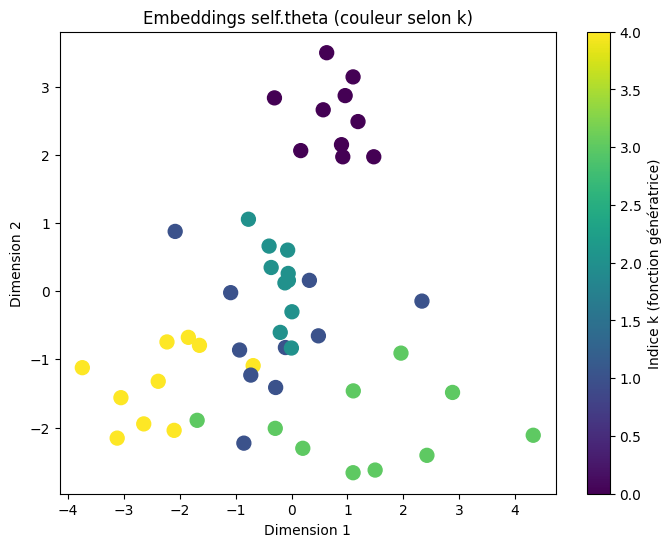

In [19]:
group_k = []
num_groups = 50
for group in range(num_groups):
    _, _, k_val, _ = dataset[group * 1000]
    group_k.append(k_val.item())

model.eval()
theta_values = model.theta.detach().cpu().numpy()

plt.figure(figsize=(8, 6))

scatter = plt.scatter(theta_values[:, 0], theta_values[:, 1],
                      c=group_k, cmap='viridis', s=100)
plt.colorbar(scatter, label="Indice k (fonction génératrice)")
plt.title("Embeddings self.theta (couleur selon k)")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()

2.

Le scatter plot obtenu à la fin de l'entraînement montre une séparation claire des 50 points (correspondant aux 50 groupes) en 5 clusters distincts. Ces clusters sont visibles grâce à la coloration des points selon l'indice k, qui représente la fonction ayant généré les cibles.

Malgré le nombre relativement faible d'epochs (20), nous pouvons déjà observer que les points ne sont pas répartis aléatoirement mais qu'ils se structurent autour de 5 régions bien distinctes. Cela signifie que le modèle a réussi à capturer une information pertinente sur la similarité des groupes entre eux.

3.

self.theta :

Contient 50 vecteurs 2D, un par groupe de 1000 exemples.
Ces embeddings sont appris pour que les groupes générés par la même fonction se rapprochent.

Vector noise :

Bruit ajouté aux embeddings pour régulariser et favoriser l'exploration de l'espace de représentation, évitant ainsi le surapprentissage.
Division par 1000 (indices // 1000) :

Convertit l'indice global (0 à 49999) en identifiant de groupe (0 à 49) afin d'associer chaque exemple à son embedding de groupe correspondant.





